# KAIST AI605 Assignment 4: Attention, Transformer, NMT, Beam Search

## Rubric

### Deadline 
The deadline for this assignment is: Friday 18th November 2022 (Week 12) 11:59pm

### Submission
Please submit your assignment via [KLMS](https://klms.kaist.ac.kr). You must submit both (1) a PDF of your solutions and (2) the Jupyter Notebook file (.ipynb).

Use in-line LaTeX for mathematical expressions. 

### Collaboration
This assignment is not a group assignment so make sure your answer and code are your own. 

**For Problem 2 of this assignment ONLY** it acceptable to use and copy code from the annotated transformer: http://nlp.seas.harvard.edu/annotated-transformer/

### Grading
The total number of marks avaiable is 30 points.

### Environment
The use of a GPU will be beneficial for this assignment.

If you do not have a GPU on your laptop, it is acceptable to use [Google Colab (free)](https://colab.research.google.com) or the departmental subscription of [VESSL](https://vessl.ai), 
**please contact me ASAP to be added if you are from a different department**.


The required environment for this is Python 3.9. Run the following cell to set up the environment.

In [1]:
# !pip install torch nltk scipy tqdm datasets

# Problem 1 - Attention (10 points)

## Problem 1.1 (8 points) - Self Attention for Natural Language Inference

Recall from Week 3 and 4, recall that Natural Language Inference is a sentence-pair classification task. Using the data from Stanford Natural Language Inference dataset (Bowman et al., 2015), build the following network implementations and compare the accuracy on the development set:

* A single LSTM model that encodes both the premise and hypothesis sentence. Then performs a classification using a feed forward network over the final hidden state.

Let $\mathbf{X}$ be the embeddings of the premise tokens concatenated with hypothesis tokens.

$$\mathbf{H}, h_n = LSTM(\mathbf{X})$$

$$P(\mathbf{y}|X) = Softmax(FF(\mathbf{h_n}))$$

* A single LSTM model that encodes both the premise and hypothesis sentence. Then performs a classification using a feed forward network over a pooling of the hidden states of every token

Let $\mathbf{X}$ be the embeddings of the premise tokens concatenated with hypothesis tokens.

$$\mathbf{H}, h_n = LSTM(\mathbf{X})$$

$$P(\mathbf{y}|X) = Softmax(Pool(\mathbf{H}))$$



* A single LSTM model that encodes both the premise and hypothesis sentence. Then performs **dot product self attention** over all the tokens. For each token, input the concatenation of the attended representation with the LSTM hidden state into a single-layer feed forward network with ReLU activation. Sum these vectors and input them to another feed forward network classifier.

Let $\mathbf{X}$ be the embeddings of the premise tokens concatenated with hypothesis tokens.

$$\mathbf{H}, \mathbf{h_n} = LSTM(\mathbf{x})$$ 

$$\alpha_{j} = DotProductAttn_j(\mathbf{H}, \mathbf{H})$$

Let $\mathbf{h}_i = \mathbf{H}_{i,:}$ be the vector of LSTM encoding for token $i$

$$\bar{\mathbf{a}}_i = \sum_j \alpha_{j}\mathbf{h}_j$$ 

$$\mathbf{z}_i = FF(\lbrack \mathbf{h}_{i}, \bar{\mathbf{a}}_i \rbrack) $$


$$P(\mathbf{y}|X) = Softmax(FF(\sum_i\mathbf{z_i}))$$


Instructions:

* Chose appropriate network architectures, activation functions, vocab size, word embeddings, training objective, loss function, dimensions and hyperparameters for the model based on examples from previous labs. 

* The data can be downloaded here: https://nlp.stanford.edu/projects/snli/ - some instances have no label ("-"). These can be ignored.

* Use of GPU acceleration can allow larger network architectures to be trained with more data. 

* The goal of this exercise is to demonstrate model properties and show that models converge during training. It is not necessary to try and achieve state of the art performance

* It may be challenging to use all data and it is acceptable to use a subset of the SNLI dataset for this question. HOWEVER, it is expected that students use a sufficient size model and sufficient number of data to demonstrate the differences between the models. 



In [2]:
# pip install collection

In [80]:
import json
import torch
from torch import nn
import json
from nltk import word_tokenize
from collections import defaultdict, Counter
import torch.nn.functional as F
import numpy as np

Data preparation: 

In [15]:
def load_instances(filename):
    with open(filename) as f:
        for line in f:
            inst = json.loads(line)
            label = inst["gold_label"]

            if label == "-":
                continue

            sent1 = word_tokenize(inst['sentence1'])
            sent2 = word_tokenize(inst['sentence2'])

            yield (sent1, sent2, label)
            
train_instances = list(load_instances("C:/Users/User/Desktop/NLP/assignment4/snli_1.0/snli_1.0_train.jsonl"))
dev_instances = list(load_instances("C:/Users/User/Desktop/NLP/assignment4/snli_1.0/snli_1.0_dev.jsonl"))

In [16]:
vocab_counter = Counter()
labels = set()
for s1, s2, label in train_instances:
    vocab_counter.update(s1)
    vocab_counter.update(s2)
    labels.add(label)

In [17]:
most_common_vocab = [a[0] for a in vocab_counter.most_common(10000)]
most_common_vocab.append("<UNK>")

In [18]:
vocab2idx = {word: idx for idx, word in enumerate(most_common_vocab)}
label2idx = {word: idx for idx, word in enumerate(labels)}

In [22]:
def vectorize(instance, vocab, labelvocab):
    s1 = [vocab.get(tok, vocab.get("<UNK>")) for tok in instance[0]]
    s2 = [vocab.get(tok, vocab.get("<UNK>")) for tok in instance[1]]

    label = labelvocab.get(instance[2])


    return (torch.LongTensor(s1), torch.LongTensor(s2), torch.LongTensor([label]))

train_vectors = [vectorize(instance, vocab2idx, label2idx) for instance in train_instances[:10000]]
dev_vectors = [vectorize(instance, vocab2idx, label2idx) for instance in dev_instances]

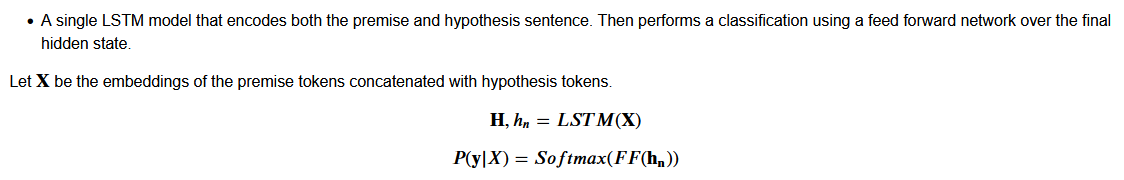

In [8]:
# class LSTM_final_state(nn.Module):
#     def __init__(self, vocab_dict, classes_dict, embedding_size, hidden_size):
#         super().__init__()
        
#         self.emb = nn.Embedding(len(vocab_dict), embedding_size)
#         self.encoder = nn.LSTM(embedding_size, hidden_size)
#         self.linear1 = nn.Linear(2*hidden_size,200)
#         self.linear2 = nn.Linear(200,200)
#         self.linear3 = nn.Linear(200,200)
#         self.classifier = nn.Linear(200, len(classes_dict))
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, premise, hypothesis):    
#         # Embeddings
#         emb_premise = self.emb(premise)    
#         emb_hypothesis = self.emb(hypothesis)
        
#         # LSTM Encoding
#         # Note output format is hidden_states, (h_n, c_n)
#         _, (enc_premise,_) = self.encoder(emb_premise)
#         _, (enc_hypothesis,_) = self.encoder(emb_hypothesis)
        
#         # Concatenate (axis=-1 = last axis)
#         combined = torch.cat([enc_premise, enc_hypothesis],axis=-1)
        
#         # Classify
#         combined = torch.tanh(self.linear1(combined))
#         combined = torch.tanh(self.linear2(combined))
#         combined = torch.tanh(self.linear3(combined))
        
#         logits = self.softmax(self.classifier(combined))
#         return logits 
    
        

In [23]:
class LSTM_final_state(nn.Module):
    def __init__(self, vocab_dict, classes_dict, embedding_size, hidden_size):
        super().__init__()
        
        self.emb = nn.Embedding(len(vocab_dict), embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size,200)
        self.linear2 = nn.Linear(200,200)
        self.linear3 = nn.Linear(200,200)
        self.classifier = nn.Linear(200, len(classes_dict))
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, premise, hypothesis):    
        
        #Concatenate premise and hypotesis
        combined = torch.cat([premise, hypothesis],axis=-1)
        # Embeddings
        emb_combined = self.emb(combined)    
        
        # LSTM Encoding
        _, (enc_combined,_) = self.encoder(emb_combined)

        # Classify
        combined = torch.tanh(self.linear1(enc_combined))
        combined = torch.tanh(self.linear2(combined))
        combined = torch.tanh(self.linear3(combined))
        
        logits = self.softmax(self.classifier(combined))
        return logits 
    
        

In [24]:
from tqdm.notebook import tqdm as tqdm

model = LSTM_final_state(vocab2idx, label2idx, 10, 20) 

cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epoch_scores = []

for epoch in range(25):
    
    correct = 0 
    total = len(dev_vectors)
    
    for s1, s2, label in tqdm(train_vectors):
        optimizer.zero_grad()
        
        logits = model(s1,s2)
        loss = cross_entropy(logits,label)
        loss.backward()
        
        optimizer.step()
        
        
    # We don't need to compute gradients when we test the model. 
    # This speeds up inference and helps prevent us from accidently training on the dev set
    with torch.no_grad():
        for s1, s2, label in tqdm(dev_vectors):
            logits = model(s1,s2)
            loss = cross_entropy(logits,label)
            
            # Our y_hat is the logit with the highest score
            prediction = torch.argmax(logits,axis=-1)
            
            # If prediction is same as the label, add to the accuracy
            correct += torch.count_nonzero(prediction == label).item()
            
        
    accuracy = correct/total
    epoch_scores.append(accuracy)
    print(f'Epoch: {epoch+1} accuracy: {accuracy}')
    

print("The epoch with the highest accuracy is: ")
print(torch.argmax(torch.tensor(epoch_scores)+1).item())
print(epoch_scores)
        

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 1 accuracy: 0.438528754318228


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 2 accuracy: 0.4650477545214387


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 3 accuracy: 0.48110140215403374


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 4 accuracy: 0.4897378581589108


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 5 accuracy: 0.500406421459053


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 6 accuracy: 0.5039626092257671


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 7 accuracy: 0.510160536476326


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 8 accuracy: 0.5083316399105873


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 9 accuracy: 0.5224547856126803


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 10 accuracy: 0.5159520422678318


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 11 accuracy: 0.5032513716724243


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 12 accuracy: 0.5170697012802276


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 13 accuracy: 0.5039626092257671


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 14 accuracy: 0.5176793334688071


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 15 accuracy: 0.5168664905507011


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 16 accuracy: 0.5048770575086364


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 17 accuracy: 0.5201178622231254


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 18 accuracy: 0.513310302783987


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 19 accuracy: 0.4919731761837025


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 20 accuracy: 0.5201178622231254


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 21 accuracy: 0.5171713066449909


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 22 accuracy: 0.48892501524080473


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 23 accuracy: 0.513310302783987


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 24 accuracy: 0.5117862223125381


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 25 accuracy: 0.5073155862629547
The epoch with the highest accuracy is: 
8
[0.438528754318228, 0.4650477545214387, 0.48110140215403374, 0.4897378581589108, 0.500406421459053, 0.5039626092257671, 0.510160536476326, 0.5083316399105873, 0.5224547856126803, 0.5159520422678318, 0.5032513716724243, 0.5170697012802276, 0.5039626092257671, 0.5176793334688071, 0.5168664905507011, 0.5048770575086364, 0.5201178622231254, 0.513310302783987, 0.4919731761837025, 0.5201178622231254, 0.5171713066449909, 0.48892501524080473, 0.513310302783987, 0.5117862223125381, 0.5073155862629547]


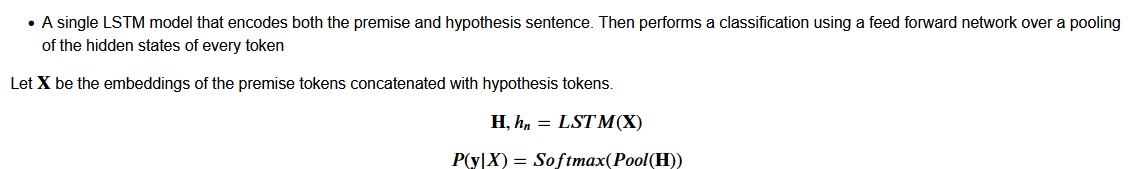

In [25]:
class LSTM_polling(nn.Module):
    def __init__(self, vocab_dict, classes_dict, embedding_size, hidden_size):
        super().__init__()
        
        self.emb = nn.Embedding(len(vocab_dict), embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size,200)
        self.linear2 = nn.Linear(200,200)
        self.linear3 = nn.Linear(200,200)
        self.classifier = nn.Linear(200, len(classes_dict))
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, premise, hypothesis):    
        #Concatenate premise and hypotesis
        combined = torch.cat([premise, hypothesis],axis=-1)
        # Embeddings
        emb_combined = self.emb(combined)    
        
        # LSTM Encoding
        h_states, (_,_) = self.encoder(emb_combined)

#         print(h_states.shape)
        polling = nn.MaxPool1d(h_states.shape[0], stride = 1)
        enc_comb = polling(torch.transpose(h_states, 0, 1))
#         print(enc_comb.shape)
        
        # Classify
        combined = torch.tanh(self.linear1(torch.transpose(enc_comb, 0, 1)))
        
        combined = torch.tanh(self.linear2(combined))
        combined = torch.tanh(self.linear3(combined))
        
               
        
        logits = self.softmax(self.classifier(combined))
#         print(logits.shape)
        return logits 
    
        

In [26]:
from tqdm.notebook import tqdm as tqdm

model = LSTM_polling(vocab2idx, label2idx, 10, 20) 

cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epoch_scores = []

for epoch in range(25):
    
    correct = 0 
    total = len(dev_vectors)
    
    model.train()
    for s1, s2, label in tqdm(train_vectors):
        optimizer.zero_grad()
        
        logits = model(s1,s2)
        loss = cross_entropy(logits,label)
        loss.backward()
        
        optimizer.step()
        
        
    # We don't need to compute gradients when we test the model. 
    # This speeds up inference and helps prevent us from accidently training on the dev set
    model.eval()
    with torch.no_grad():
        for s1, s2, label in tqdm(dev_vectors):
            logits = model(s1,s2)
            loss = cross_entropy(logits,label)
            
            # Our y_hat is the logit with the highest score
            prediction = torch.argmax(logits,axis=-1)
            
            # If prediction is same as the label, add to the accuracy
            correct += torch.count_nonzero(prediction == label).item()
            
        
    accuracy = correct/total
    epoch_scores.append(accuracy)
    print(f'Epoch: {epoch+1} accuracy: {accuracy}')
    

print("The epoch with the highest accuracy is: ")
print(torch.argmax(torch.tensor(epoch_scores)+1).item())
print(epoch_scores)
        

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 1 accuracy: 0.42806340174761226


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 2 accuracy: 0.45397276976224343


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 3 accuracy: 0.45895143263564314


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 4 accuracy: 0.45295671611461086


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 5 accuracy: 0.46301564722617355


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 6 accuracy: 0.4670798618167039


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 7 accuracy: 0.4769355821987401


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 8 accuracy: 0.4798821377768746


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 9 accuracy: 0.4799837431416379


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 10 accuracy: 0.4842511684616948


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 11 accuracy: 0.48160942897785003


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 12 accuracy: 0.4878073562284089


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 13 accuracy: 0.4931924405608616


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 14 accuracy: 0.4899410688884373


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 15 accuracy: 0.4940052834789677


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 16 accuracy: 0.4979678927047348


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 17 accuracy: 0.5006096321885796


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 18 accuracy: 0.5034545824019508


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 19 accuracy: 0.5


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 20 accuracy: 0.5025401341190815


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 21 accuracy: 0.5005080268238163


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 22 accuracy: 0.4974598658809185


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 23 accuracy: 0.4868929079455395


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 24 accuracy: 0.48882340987604145


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 25 accuracy: 0.5048770575086364
The epoch with the highest accuracy is: 
24
[0.42806340174761226, 0.45397276976224343, 0.45895143263564314, 0.45295671611461086, 0.46301564722617355, 0.4670798618167039, 0.4769355821987401, 0.4798821377768746, 0.4799837431416379, 0.4842511684616948, 0.48160942897785003, 0.4878073562284089, 0.4931924405608616, 0.4899410688884373, 0.4940052834789677, 0.4979678927047348, 0.5006096321885796, 0.5034545824019508, 0.5, 0.5025401341190815, 0.5005080268238163, 0.4974598658809185, 0.4868929079455395, 0.48882340987604145, 0.5048770575086364]


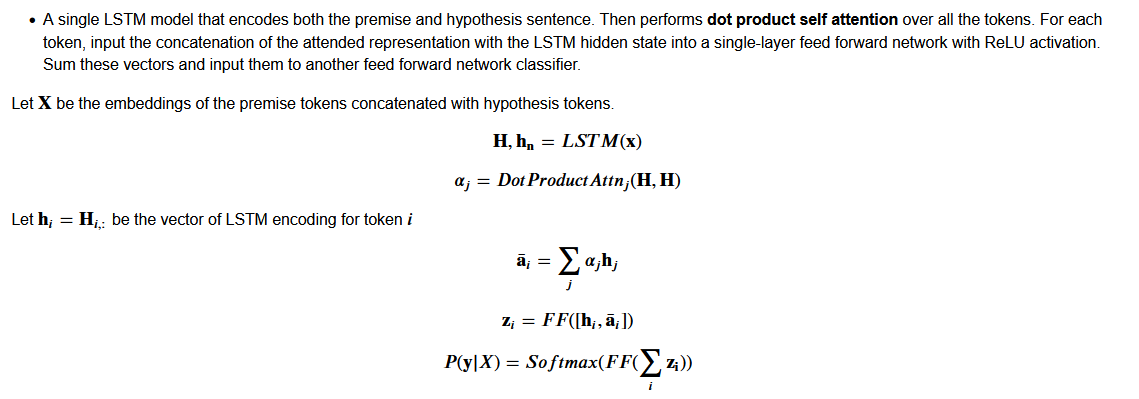

In [27]:
class LSTM_dot(nn.Module):
    def __init__(self, vocab_dict, classes_dict, embedding_size, hidden_size):
        super().__init__()
        
        self.emb = nn.Embedding(len(vocab_dict), embedding_size)
        self.encoder = nn.LSTM(embedding_size, hidden_size)
        self.linear1 = nn.Linear(hidden_size+1,200)
        self.linear2 = nn.Linear(200,200)
        self.linear3 = nn.Linear(200,200)
        self.classifier = nn.Linear(200, len(classes_dict))
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, premise, hypothesis):    
        #Concatenate premise and hypotesis
        combined = torch.cat([premise, hypothesis],axis=-1)
        # Embeddings
        emb_combined = self.emb(combined)    
        
        # LSTM Encoding
        H_states, (h_state,_) = self.encoder(emb_combined)
#         print(H_states.shape)
        # dot product 
        a = torch.matmul(H_states,H_states.T)
#         print(a.shape)
        
        a = torch.sum(torch.matmul(a,H_states), dim = 1)
#         print(a.shape)
        z = torch.cat([H_states, a.view(-1,1)],axis=1)
        
        z = torch.tanh(self.linear1(z))
#         print(z.shape)
        z_sum = torch.sum(z, dim = 0)
#         print(z_sum.shape)
        z_sum = torch.tanh(self.linear2(z_sum))
        z_sum = torch.tanh(self.linear3(z_sum))
               
        
        logits = self.softmax(self.classifier(z_sum.view(1,-1)))
#         print(logits.shape)
        return logits 
    
        

In [28]:
from tqdm.notebook import tqdm as tqdm

model = LSTM_dot(vocab2idx, label2idx, 10, 20) 

cross_entropy = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

epoch_scores = []

for epoch in range(25):
    
    correct = 0 
    total = len(dev_vectors)
    
    model.train()
    for s1, s2, label in tqdm(train_vectors):
        optimizer.zero_grad()
        
        logits = model(s1,s2)
        loss = cross_entropy(logits,label)
        loss.backward()
        
        optimizer.step()
        
        
    # We don't need to compute gradients when we test the model. 
    # This speeds up inference and helps prevent us from accidently training on the dev set
    model.eval()
    with torch.no_grad():
        for s1, s2, label in tqdm(dev_vectors):
            logits = model(s1,s2)
            loss = cross_entropy(logits,label)
            
            # Our y_hat is the logit with the highest score
            prediction = torch.argmax(logits,axis=-1)
            
            # If prediction is same as the label, add to the accuracy
            correct += torch.count_nonzero(prediction == label).item()
            
        
    accuracy = correct/total
    epoch_scores.append(accuracy)
    print(f'Epoch: {epoch+1} accuracy: {accuracy}')
    

print("The epoch with the highest accuracy is: ")
print(torch.argmax(torch.tensor(epoch_scores)+1).item())
print(epoch_scores)
        

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 1 accuracy: 0.3700467384677911


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 2 accuracy: 0.3580573054257265


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 3 accuracy: 0.36710018288965657


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 4 accuracy: 0.3814265393212762


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 5 accuracy: 0.39250152408047145


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 6 accuracy: 0.3917902865271286


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 7 accuracy: 0.4057102214996952


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 8 accuracy: 0.41282259703312335


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 9 accuracy: 0.4219670798618167


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 10 accuracy: 0.43344848608006503


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 11 accuracy: 0.4145498882340988


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 12 accuracy: 0.44360902255639095


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 13 accuracy: 0.4472668156878683


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 14 accuracy: 0.4595610648242227


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 15 accuracy: 0.4669782564519407


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 16 accuracy: 0.45895143263564314


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 17 accuracy: 0.4766307661044503


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 18 accuracy: 0.4725665515139199


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 19 accuracy: 0.4444218654744971


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 20 accuracy: 0.47297297297297297


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 21 accuracy: 0.464742938427149


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 22 accuracy: 0.4817110343426133


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 23 accuracy: 0.4800853485064011


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 24 accuracy: 0.4722617354196302


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/9842 [00:00<?, ?it/s]

Epoch: 25 accuracy: 0.46860394228815283
The epoch with the highest accuracy is: 
21
[0.3700467384677911, 0.3580573054257265, 0.36710018288965657, 0.3814265393212762, 0.39250152408047145, 0.3917902865271286, 0.4057102214996952, 0.41282259703312335, 0.4219670798618167, 0.43344848608006503, 0.4145498882340988, 0.44360902255639095, 0.4472668156878683, 0.4595610648242227, 0.4669782564519407, 0.45895143263564314, 0.4766307661044503, 0.4725665515139199, 0.4444218654744971, 0.47297297297297297, 0.464742938427149, 0.4817110343426133, 0.4800853485064011, 0.4722617354196302, 0.46860394228815283]


## Problem 1.2 (2 points) - Attention Types

Compare the attention mechanisms of Dot Product self attention, Bahdanau (concatenate) attention and Luong (linear) attention from the lecture in Week 10. Assuming a hidden dimension size of $d$ dimensions, compare how many additional parameters these attention mechanisms introduce.

# Problem 2 - Transformer for NMT (12 points)

## Problem 2.1 (2 points) - Multi-Head Attention
Assume that multi-head attention with 12 attention heads is used in an encoder-decoder transformer model which has a hidden dimension size of 512. How many parameters in this encoder-decoder model with 12 layers are used for the multi-head attention? (Based on the model architecture from "Attention is all you need", Vaswani et al., 2017). Show your working.

## Problem 2.2 (2 points) - Residual Connections
The transformer architecture uses residual connections (https://arxiv.org/pdf/1512.03385.pdf) over both the feedforward and multi-head attention sub-layers. Describe how these residual connections function and compare the derivative of the loss ($\frac{\partial L}{\partial \mathbf{x}}$) of a 2-layer feed-forward layer and a feed-forward layer with relu activation ($\mathbf{z}= \mathbf{W}_2 \text{ReLU}(\mathbf{W}_1 \mathbf{x} + \mathbf{b_1}) + \mathbf{b_2}$) both with and without the residual connection


## Problem 2.3 (8 points) - Training a transformer
Using the code from the Week 10 lab or the annotated tranformer (link at top of notebook). Train and evaluate an appropriately sized transformer model for the task of translating Korean TED Talks to English.  The dataset can be downloaded using the HuggingFace datasets library: https://huggingface.co/datasets/msarmi9/korean-english-multitarget-ted-talks-task 

* Only use the Korean-English translation part of this dataset
* Chose appropriate network architecture, vocabulary, tokenization and hyper-parameters.
* It is not neccesary to get very high performance of model. It is only required to show that training converges for a few epochs and that the model generates intelligible outputs.
* It is acceptable to use a subset of the data (training the network on all data make take a long time) 
* Use teacher forcing when training your model
* Decode predictions at inference time using greedy search
* It is recommended to use GPUs to speed up training

In [63]:
# reading data 
def load_data(filename):
    with open(filename, encoding="utf8") as f:
        for item in f:
            inst = json.loads(item)

            yield inst
            
train_instances = list(load_data("C:/Users/User/Desktop/NLP/assignment4/task_2/train.json"))
dev_instances = list(load_data("C:/Users/User/Desktop/NLP/assignment4/task_2/dev.json"))

# checking if the data loaded properly 
print(len(train_instances))
print(len(dev_instances))
train_instances[1000]

166215
1958


{'korean': '제가 아주 심한 화상을 입었을 때였죠.', 'english': 'I was burned very badly.'}

In [67]:
english_tokenized=[]
korean_tokenized=[]
for i in tqdm(range(len(train_instances))):
    eng_sentence = word_tokenize(train_instances[i]['english'])
    kr_sentence = word_tokenize(train_instances[i]['korean']) #, language="korean")
    english_tokenized.append(eng_sentence)
    korean_tokenized.append(kr_sentence)

  0%|          | 0/166215 [00:00<?, ?it/s]

In [69]:
korean_tokenized[1000]

['제가', '아주', '심한', '화상을', '입었을', '때였죠', '.']

In [73]:
en_word2index = {"SOS": 0, "EOS": 1, "UNK": 2, "PAD": 3} 
en_word2count = {"SOS": 10, "EOS": 10, "UNK": 10, "PAD":10}
en_index2word = {0: "SOS", 1: "EOS", 2: "UNK", 3: "PAD"}
en_n_word=4

for sentence in tqdm(english_tokenized):
    for token in sentence:
        if token not in en_word2index:
            en_word2index[token] =en_n_word
            en_index2word[en_n_word]=token
            en_word2count[token] = 1
            en_n_word += 1
        else:
            en_word2count[token] += 1

kr_word2index = {"SOS": 0, "EOS": 1, "UNK": 2, "PAD": 3} 
kr_word2count = {"SOS": 10, "EOS": 10, "UNK": 10, "PAD": 10}
kr_index2word = {0: "SOS", 1: "EOS", 2: "UNK", 3: "PAD"}
kr_n_word=4

for sentence in tqdm(korean_tokenized):
    for token in sentence:
        if token not in kr_word2index:
            kr_word2index[token] =kr_n_word
            kr_index2word[kr_n_word]=token
            kr_word2count[token] = 1
            kr_n_word += 1
        else:
            kr_word2count[token] += 1

  0%|          | 0/166215 [00:00<?, ?it/s]

  0%|          | 0/166215 [00:00<?, ?it/s]

In [75]:
en_train_data=[]
for sentence in tqdm(english_tokenized):
    sentence_idx = [en_word2index[w] if w in en_word2index else en_word2index['UNK'] for w in sentence ]
    sentence_idx = [0] + sentence_idx + [1] # add "SOS"&"EOS" token
    sentence_idx = torch.LongTensor(sentence_idx)
    en_train_data.append(sentence_idx)

kr_train_data=[]
for sentence in tqdm(korean_tokenized):
    sentence_idx = [kr_word2index[w] if w in kr_word2index else kr_word2index['UNK'] for w in sentence]
    sentence_idx = [0] + sentence_idx + [1] # add "EOS" token
    sentence_idx = torch.LongTensor(sentence_idx)
    kr_train_data.append(sentence_idx)
    

  0%|          | 0/166215 [00:00<?, ?it/s]

  0%|          | 0/166215 [00:00<?, ?it/s]

In [78]:
# Preprocess devset

english_dev_tokenized=[]
korean_dev_tokenized=[]
for i in tqdm(range(len(dev_instances))):
    eng_sentence = word_tokenize(dev_instances[i]['english'])
    kr_sentence = word_tokenize(dev_instances[i]['korean'])
    english_dev_tokenized.append(eng_sentence)
    korean_dev_tokenized.append(kr_sentence)

en_dev_data=[]
for sentence in tqdm(english_dev_tokenized):
    sentence_idx = [en_word2index[w] if w in en_word2index else en_word2index['UNK'] for w in sentence ]
    sentence_idx = [0] + sentence_idx + [1] # add "SOS" & "EOS" token
    sentence_idx = torch.LongTensor(sentence_idx)
    en_dev_data.append(sentence_idx)

kr_dev_data=[]
for sentence in tqdm(korean_dev_tokenized):
    sentence_idx = [kr_word2index[w] if w in kr_word2index else kr_word2index['UNK'] for w in sentence]
    sentence_idx = [0] + sentence_idx + [1] # add "EOS" token /  "SOS" token would be added in training step!
    sentence_idx = torch.LongTensor(sentence_idx)
    kr_dev_data.append(sentence_idx)

  0%|          | 0/1958 [00:00<?, ?it/s]

  0%|          | 0/1958 [00:00<?, ?it/s]

  0%|          | 0/1958 [00:00<?, ?it/s]

In [81]:
padding_token = en_word2count["PAD"]
en_train_max = np.max([len(en_train_data[i]) for i in range(len(en_train_data))])
kr_train_max = np.max([len(kr_train_data[i]) for i in range(len(kr_train_data))])
en_dev_max = np.max([len(en_dev_data[i]) for i in range(len(en_dev_data))])
kr_dev_max = np.max([len(kr_dev_data[i]) for i in range(len(kr_dev_data))])
max_len = np.max([en_train_max, kr_train_max, en_dev_max, kr_dev_max])
print(max_len)
# Pad the tokens to fix the length
en_train_data = [torch.cat([i, torch.zeros(max_len-len(i), dtype=torch.long) + en_word2index["PAD"]]) if len(i) < max_len+1 else i[:max_len] for i in en_train_data]
en_dev_data = [torch.cat([i, torch.zeros(max_len-len(i), dtype=torch.long) + en_word2index["PAD"]]) if len(i) < max_len+1 else i[:max_len] for i in en_dev_data]
kr_train_data = [torch.cat([i, torch.zeros(max_len-len(i), dtype=torch.long) + kr_word2index["PAD"]]) if len(i) < max_len else i[:max_len] for i in kr_train_data]
kr_dev_data = [torch.cat([i, torch.zeros(max_len-len(i), dtype=torch.long) + kr_word2index["PAD"]]) if len(i) < max_len else i[:max_len] for i in kr_dev_data]


174


![transforemr](https://miro.medium.com/max/856/1*ZCFSvkKtppgew3cc7BIaug.png)

In [113]:
import torch.nn as nn
import torch.nn.functional as F
import math

class SelfAttention(nn.Module):
    def __init__(self):
        super(SelfAttention,self).__init__()
        self.matmul = torch.matmul
        self.softmax = torch.softmax

    def forward(self,query, key, value, mask=None):
        key_transpose = torch.transpose(key,-2,-1)          # (bath, head_num, d_k, token_)
        matmul_result = self.matmul(query,key_transpose)    # MatMul(Q,K)
        d_k = key.size()[-1]
        attention_score = matmul_result/math.sqrt(d_k)      # Scale

        if mask is not None:
            attention_score = attention_score.masked_fill(mask == 0, -1e20)

            softmax_attention_score = self.softmax(attention_score,dim=-1)
            result = self.matmul(softmax_attention_score,value)

        return result, softmax_attention_score
    
class MultiHeadAttention(nn.Module):
    def __init__(self, head_num =8 , d_model = 512,dropout = 0.1):
        super(MultiHeadAttention,self).__init__()

        assert d_model % head_num == 0 

        self.head_num = head_num
        self.d_model = d_model
        self.d_k = self.d_v = d_model // head_num

        self.w_q = nn.Linear(d_model,d_model)
        self.w_k = nn.Linear(d_model,d_model)
        self.w_v = nn.Linear(d_model,d_model)
        self.w_o = nn.Linear(d_model,d_model)

        self.self_attention = SelfAttention()
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask = None):
        if mask is not None:
          # Same mask applied to all h heads.
          mask = mask.unsqueeze(1)

        batche_num = query.size(0)

        query = self.w_q(query).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
        key = self.w_k(key).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)
        value = self.w_v(value).view(batche_num, -1, self.head_num, self.d_k).transpose(1, 2)

        attention_result, attention_score = self.self_attention(query, key, value, mask)

        attention_result = attention_result.transpose(1,2).contiguous().view(batche_num, -1, self.head_num * self.d_k)


        return self.w_o(attention_result)

from torch.autograd import Variable

class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm,self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    def forward(self, x):
        mean = x.mean(-1, keepdim =True)
        std = x.std(-1, keepdim=True) 

        return self.a_2 * (x-mean)/ (std + self.eps) + self.b_2

class ResidualConnection(nn.Module):
    def __init__(self, size, dropout):
        super(ResidualConnection,self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return x + self.dropout((sublayer(self.norm(x))))
    
class Embeddings(nn.Module):
    def __init__(self, vocab_num, d_model):
            super(Embeddings,self).__init__()
            self.emb = nn.Embedding(vocab_num,d_model)
            self.d_model = d_model
    def forward(self, x):
        return self.emb(x) * math.sqrt(self.d_model)
    
class PositionalEncoding(nn.Module):
    def __init__(self, max_seq_len, d_model,dropout=0.1):
        super(PositionalEncoding,self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_seq_len, d_model)

        position = torch.arange(0,max_seq_len).unsqueeze(1)
        base = torch.ones(d_model//2).fill_(10000)
        pow_term = torch.arange(0, d_model, 2) / torch.tensor(d_model,dtype=torch.float32)
        div_term = torch.pow(base,pow_term)

        pe[:, 0::2] = torch.sin(position / div_term)
        pe[:, 1::2] = torch.cos(position / div_term)

        pe = pe.unsqueeze(0)

        # Do not train pe!
        self.register_buffer('positional_encoding', pe)

    def forward(self, x):
#         print(x.shape)
# #         print(x.size(1))
#         print(Variable(self.positional_encoding[:, :x.size(1)], requires_grad=False).shape)
        x = x + Variable(self.positional_encoding[:, :x.size(1)], requires_grad=False)
        return self.dropout(x)
    
class FeedForward(nn.Module):
    def __init__(self,d_model, dropout = 0.1):
        super(FeedForward,self).__init__()
        self.w_1 = nn.Linear(d_model, d_model*4)
        self.w_2 = nn.Linear(d_model*4, d_model)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        return self.w_2(self.dropout(F.relu(self.w_1(x))))
    
import copy
# to stack the layer!
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

def make_pad_mask(query, key, pad_idx=3):
    # key: (n_batch, key_seq_len)
    query_seq_len, key_seq_len = len(query), len(key)
    key_mask = key.ne(pad_idx)

    key_mask = key_mask.repeat(1, 1, query_seq_len, 1)    # (n_batch, 1, query_seq_len, key_seq_len)

    query_mask = query.ne(pad_idx).unsqueeze(0)  # (n_batch, 1, query_seq_len, 1)
    query_mask = query_mask.transpose(-1,0).repeat(1, 1, 1, key_seq_len)  # (n_batch, 1, query_seq_len, key_seq_len)

    mask = key_mask & query_mask
    mask = mask.squeeze(0)
    mask.requires_grad = False
    return mask

class Encoder(nn.Module):
    def __init__(self, d_model, head_num, dropout):
        super(Encoder,self).__init__()
        self.multi_head_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
        self.residual_1 = ResidualConnection(d_model,dropout=dropout)

        self.feed_forward = FeedForward(d_model)
        self.residual_2 = ResidualConnection(d_model,dropout=dropout)

    def forward(self, input, mask):
        x = self.residual_1(input, lambda x: self.multi_head_attention(x, x, x, mask))
        x = self.residual_2(x, lambda x: self.feed_forward(x))
        return x
    
class Decoder(nn.Module):
    def __init__(self, d_model,head_num, dropout):
        super(Decoder,self).__init__()
        self.masked_multi_head_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
        self.residual_1 = ResidualConnection(d_model,dropout=dropout)

        self.encoder_decoder_attention = MultiHeadAttention(d_model= d_model, head_num= head_num)
        self.residual_2 = ResidualConnection(d_model,dropout=dropout)

        self.feed_forward= FeedForward(d_model)
        self.residual_3 = ResidualConnection(d_model,dropout=dropout)


    def forward(self, target, encoder_output, target_mask, encoder_mask):
        # target, x, target_mask, input_mask
        x = self.residual_1(target, lambda x: self.masked_multi_head_attention(x, x, x, target_mask))
        x = self.residual_2(x, lambda x: self.encoder_decoder_attention(x, encoder_output, encoder_output, encoder_mask))
        x = self.residual_3(x, self.feed_forward)

        return x
    
class Generator(nn.Module):
    "Define standard linear + softmax generation step."
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

class Transformer(nn.Module):
    def __init__(self,input_vocab_num, output_vocab_num, d_model, max_seq_len, head_num, dropout, N):
        super(Transformer,self).__init__()
        self.input_embedding = Embeddings(input_vocab_num, d_model)
        self.output_embedding = Embeddings(output_vocab_num, d_model)
        self.positional_encoding = PositionalEncoding(max_seq_len,d_model)

        self.encoders = clones(Encoder(d_model=d_model, head_num=head_num, dropout=dropout), N)
        self.decoders = clones(Decoder(d_model=d_model, head_num=head_num, dropout=dropout), N)

        self.generator = Generator(d_model, output_vocab_num)

    def forward(self, inputs, target, input_mask, target_mask, labels=None):
        x = self.positional_encoding(self.input_embedding(inputs))
        for encoder in self.encoders:
            x = encoder(x, input_mask)

        target = self.positional_encoding(self.output_embedding(target))
        for decoder in self.decoders:
            # target, encoder_output, target_mask, encoder_mask)
            target = decoder(target, x, target_mask, input_mask)

        lm_logits = self.generator(target)
        loss = None
        if labels is not None:
            # Shift so that tokens < n predict n
            shift_logits = lm_logits[..., :-1, :].contiguous()
            shift_labels = labels[..., 1:].contiguous()
            # Flatten the tokens
            loss_fct = nn.CrossEntropyLoss(ignore_index=3)
            loss = loss_fct(shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1))

        return lm_logits, loss
    def encode(self,input, input_mask):
        x = self.positional_encoding(self.input_embedding(input))
        for encoder in self.encoders:
            x = encoder(x, input_mask)
        return x

    def decode(self, encode_output, encoder_mask, target, target_mask):
        target = self.positional_encoding(self.output_embedding(target))
        for decoder in self.decoders:
        #target, encoder_output, target_mask, encoder_mask
            target = decoder(target, encode_output, target_mask, encoder_mask)

            lm_logits = self.generator(target)

        return lm_logits


In [114]:
#training step
from torch.optim import Adam
from nltk.translate.bleu_score import sentence_bleu
import random
from tqdm import tqdm
import math

#Basic Hyper-parameters
epochs = 2
hidden_size = 464
max_len = 174
att_n = 4
dropout_rate = 0.2
num_stack = 2

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
# device='cpu'

model = Transformer(len(en_word2index), len(kr_word2index), hidden_size, max_len, att_n, dropout_rate, num_stack)
optimizer = Adam(model.parameters(), lr=1e-3)
losses = []

model = model.to(device)
model.train()

for epoch in range(epochs):
    
    # criterion.to(device)
    for i, batch in tqdm(enumerate(zip(en_train_data, kr_train_data))):
        # if i < 1000:
        en_sentence, kr_sentence = batch
        en_sentence = en_sentence.to(device)
        kr_sentence = kr_sentence.to(device)
        source_mask = make_pad_mask(en_sentence, en_sentence).to(device) # do not attend [PAD] tokens
        target_pad_mask = make_pad_mask(kr_sentence, kr_sentence).to(device)
        target_subseq_mask = subsequent_mask(len(kr_sentence)).to(device)
        target_mask = target_pad_mask & target_subseq_mask
        
        optimizer.zero_grad()
        logits, loss = model(en_sentence, kr_sentence, source_mask, target_mask, labels=en_sentence)       
        # input = fr_sentence[t]
        losses.append(loss.item())
        loss.backward()
        optimizer.step()


cpu


637it [1:35:35,  9.00s/it]


KeyboardInterrupt: 

In [ ]:
#check the train_loss
from matplotlib import pyplot as plt
losses
samples = np.linspace(0, 2*8480, num = len(losses))
plt.plot(samples, losses, color = "blue", label=losses)
plt.title("training_loss")
plt.show()

In [ ]:
#evaluate
from nltk.translate.bleu_score import sentence_bleu

target_length=12
scores=0.0

with torch.no_grad():
    for i, batch in tqdm(enumerate(zip(en_dev_data, fr_dev_data))):
        en_sentence, fr_sentence = batch
        en_sentence = en_sentence.to(device)
        fr_sentence = fr_sentence.to(device)
        
        source_mask = make_pad_mask(en_sentence, en_sentence).to(device) # do not attend [PAD] tokens
        
        target_pad_mask = make_pad_mask(fr_sentence,fr_sentence).to(device)
        target_subseq_mask = subsequent_mask(len(fr_sentence)).to(device) # do not attend next tokens !
        target_mask = target_pad_mask & target_subseq_mask
        
        encoder_output = model.encode(en_sentence, source_mask)
        
        # input = torch.tensor(0, device=device)
        
        # outputs = torch.zeros(target_length, 1, fr_n_word, device=device) # length * batch_size * vocab_size
        
        decoded_sentence = torch.zeros(1,1).fill_(fr_word2index['SOS']).type_as(en_sentence.data)
        for t in range(1, target_length):
            cross_mask = source_mask[:,:t,:]
            target_mask = subsequent_mask(decoded_sentence.size(1)).to(device)
            output = model.decode(encoder_output, cross_mask, decoded_sentence, target_mask) 
            prob = output[:,-1]
            _, next_word = torch.max(prob, dim=1)
            if int(next_word) == fr_word2index['EOS']:
                break
            else:
                decoded_sentence = torch.cat([decoded_sentence, torch.zeros(1,1).type_as(en_sentence.data).fill_(next_word.item())], dim=1)
        
        num_pad = fr_sentence.tolist().count(3)
        fr_sentence = fr_sentence[1:-num_pad-1]
        truth = [fr_index2word[int(w)] if int(w) in fr_index2word.keys() else 'UNK' for w in fr_sentence ]
        decoded_sentence = decoded_sentence.tolist()[0]
        decoded_sentence = [fr_index2word[int(w)] if int(w) in fr_index2word.keys() else 'UNK' for w in decoded_sentence]
        decoded_sentence = decoded_sentence[1:]
        
        scores += sentence_bleu([truth], decoded_sentence, weights=[0.75, 0.25]) 
        
        if i % 1000 == 0:
            print(f"==============check the {i}th output================")
            model_output = ' '.join(decoded_sentence)
            truth = ' '.join(truth)
            print(f"original_sentence: {truth}")
            print(f"model_output: {model_output}")
    print(f"average sentence_bleu: {scores/len(en_dev_data)}")
        # score = scorer.score(fr_sentence, )

# Problem 3 - Beam Search (8 points)

## Problem 3.1 (5 points) - Make Test Time Predictions with Beam Search
Implement Beam Search and make predictions on your pre-trained model from Problem 2.3 using Beam Search (without sampling). Choose an appropriate number of beams and compare how the beam size effects the quality of translation and runtime performance. 

*If your model from Problem 2.3 is not working well, it is acceptable to use the GRU encoder-decoder model from Week 9 Lab instead*

In [ ]:
#evaluate
from nltk.translate.bleu_score import sentence_bleu

target_length=12
scores=0.0

with torch.no_grad():
    for i, batch in tqdm(enumerate(zip(en_dev_data, fr_dev_data))):
        en_sentence, fr_sentence = batch
        en_sentence = en_sentence.to(device)
        fr_sentence = fr_sentence.to(device)
        
        source_mask = make_pad_mask(en_sentence, en_sentence).to(device) 
        
        target_pad_mask = make_pad_mask(fr_sentence,fr_sentence).to(device)
        target_subseq_mask = subsequent_mask(len(fr_sentence)).to(device) 
        target_mask = target_pad_mask & target_subseq_mask
        
        encoder_output = model.encode(en_sentence, source_mask)
        
        decoded_sentence = torch.zeros(1,1).fill_(fr_word2index['SOS']).type_as(en_sentence.data)
        for t in range(1, target_length):
            cross_mask = source_mask[:,:t,:]
            target_mask = subsequent_mask(decoded_sentence.size(1)).to(device)
            output = model.decode(encoder_output, cross_mask, decoded_sentence, target_mask) 
            prob = output[:,-1]
            _, next_word = torch.max(prob, dim=1)
            if int(next_word) == fr_word2index['EOS']:
                break
            else:
                decoded_sentence = torch.cat([decoded_sentence, torch.zeros(1,1).type_as(en_sentence.data).fill_(next_word.item())], dim=1)
        
        num_pad = fr_sentence.tolist().count(3)
        fr_sentence = fr_sentence[1:-num_pad-1]
        truth = [fr_index2word[int(w)] if int(w) in fr_index2word.keys() else 'UNK' for w in fr_sentence ]
        decoded_sentence = decoded_sentence.tolist()[0]
        decoded_sentence = [fr_index2word[int(w)] if int(w) in fr_index2word.keys() else 'UNK' for w in decoded_sentence]
        decoded_sentence = decoded_sentence[1:]
        
        scores += sentence_bleu([truth], decoded_sentence, weights=[0.75, 0.25]) 
        
        if i % 1000 == 0:
            print(f"==============check the {i}th output================")
            model_output = ' '.join(decoded_sentence)
            truth = ' '.join(truth)
            print(f"original_sentence: {truth}")
            print(f"model_output: {model_output}")
    print(f"average sentence_bleu: {scores/len(en_dev_data)}")
        # score = scorer.score(fr_sentence, )

## Problem 3.2 (3 points) - Sampling at test time
It is possible to generate more diverse sentences at test time with sampling.

Setting an appropriate sample temperature hyper-parameter ($\tau$) allows control over the diversity of the generated outputs. 

$$
\text{Softmax}(\frac{\mathbf{z}}{\tau})
$$

Extend your implementation of Beam Search from Problem 3.1 to sample $k$ hypotheses instead of selecting the top-$k$. Show, both analytically and empirically, how the sample temperature affects diversity. 